### Importing Skin Cancer Data
####

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
#!pip install patool 

In [5]:
#import patoolib

In [6]:
#patoolib.extract_archive('D:\\Work\PG Programe\\Melonima Assigment\\CNN_Assignment.zip', outdir='D:\\Work\\PG Programe\\Melonima Assigment\\unzipped')

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("D:\\Work\\PG Programe\\Melonima Assigment\\unzipped\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train")
data_dir_test = pathlib.Path("D:\\Work\\PG Programe\\Melonima Assigment\\unzipped\\Skin cancer ISIC The International Skin Imaging Collaboration\\Test")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [11]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [12]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [15]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)


['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [14]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [15]:
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))

32
32


32
32


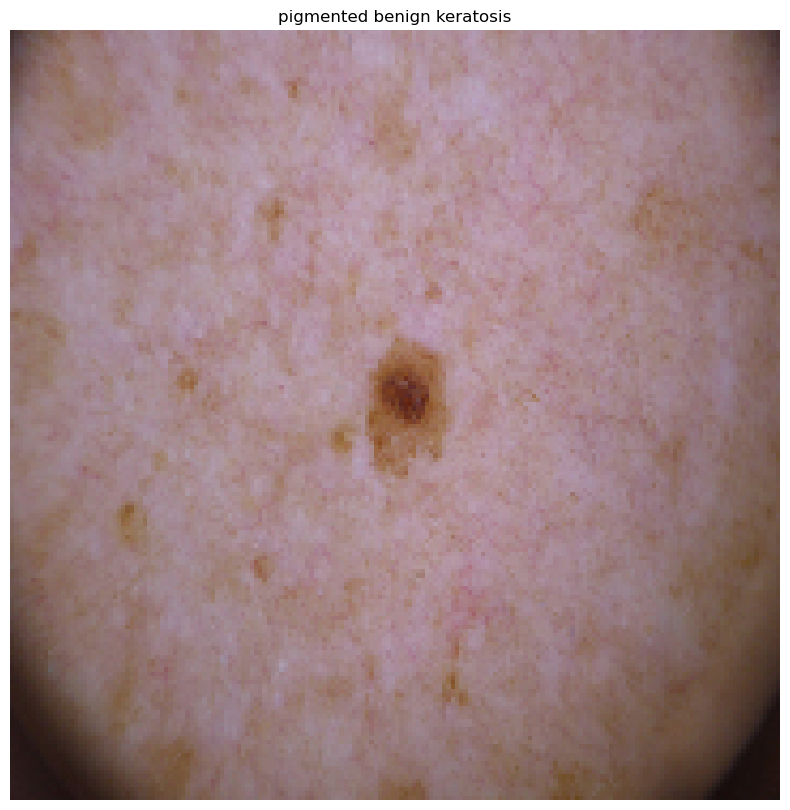

In [16]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))
  plt.imshow(images[0].numpy().astype("uint8"))
  plt.title(class_names[labels[0]])
  plt.axis("off")


### Visualize the data

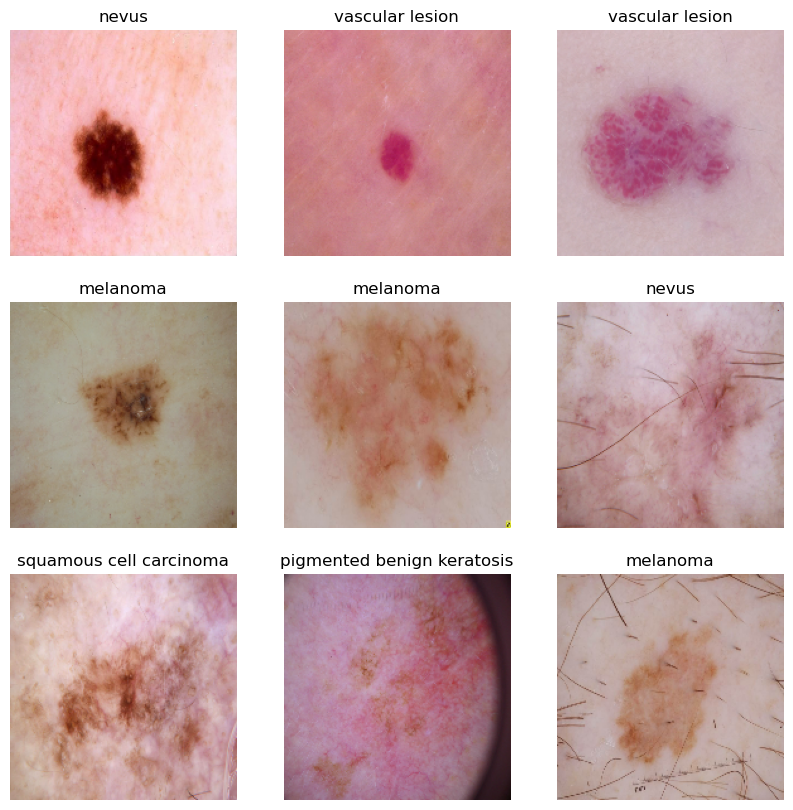

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [18]:
#print(type(train_ds))
#print(len(train_ds)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [8]:
#overlaps data preprocessing and model execution while training., Speed up training
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

NameError: name 'train_ds' is not defined

### Create the model - MODEL 1
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [20]:
### Your code goes here
num_classes = 9

#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  #2D convolution layer (e.g. spatial convolution over images).
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
  layers.MaxPooling2D(),

  #We slide over the feature map and extract tiles of a specified size.
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.MaxPooling2D(),

  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  ##Flattens the input. Does not affect the batch size.
  layers.Flatten(),

  #fully connected layer
  #A hidden layer in which each node is connected to every node in the subsequent hidden layer.
  #A fully connected layer is also known as a dense layer.

  layers.Dense(128, activation='relu'),

  #Dense is the only actual network layer in that model. A Dense layer feeds all outputs from the previous layer to all its neurons, each neuron providing one output to the next layer.
  #It's the most basic layer in neural networks. A Dense(10) has ten neurons. A Dense(512) has 512 neurons.
  #Dense implements the operation: output = activation(dot(input, kernel)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])



### Compile the model
Choose an appropirate optimiser and loss function for model training

In [21]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
### Todo, choose an appropirate optimiser and loss function
#RMSprop. RMSprop is a very effective, but currently unpublished adaptive learning rate method
#Adam. Adam is a recently proposed update that looks a bit like RMSProp with momentum. The (simplified) update looks as follows:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 461ms/step - accuracy: 0.2112 - loss: 2.1835 - val_accuracy: 0.3110 - val_loss: 1.8142
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 342ms/step - accuracy: 0.3711 - loss: 1.7201 - val_accuracy: 0.5056 - val_loss: 1.5042
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 326ms/step - accuracy: 0.4810 - loss: 1.4587 - val_accuracy: 0.5280 - val_loss: 1.4209
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 322ms/step - accuracy: 0.5498 - loss: 1.2844 - val_accuracy: 0.5459 - val_loss: 1.3710
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 336ms/step - accuracy: 0.5608 - loss: 1.2508 - val_accuracy: 0.5101 - val_loss: 1.3881
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 333ms/step - accuracy: 0.5959 - loss: 1.1571 - val_accuracy: 0.5727 - val_loss: 1.3362
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 383ms/step - accuracy: 0.6181 - loss: 1.0697 - val_accuracy: 0.5548 - val_loss: 1.3923
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 27s 483ms/step - accuracy: 0.6105 - loss: 1.1025 - val_accu

### Train the model

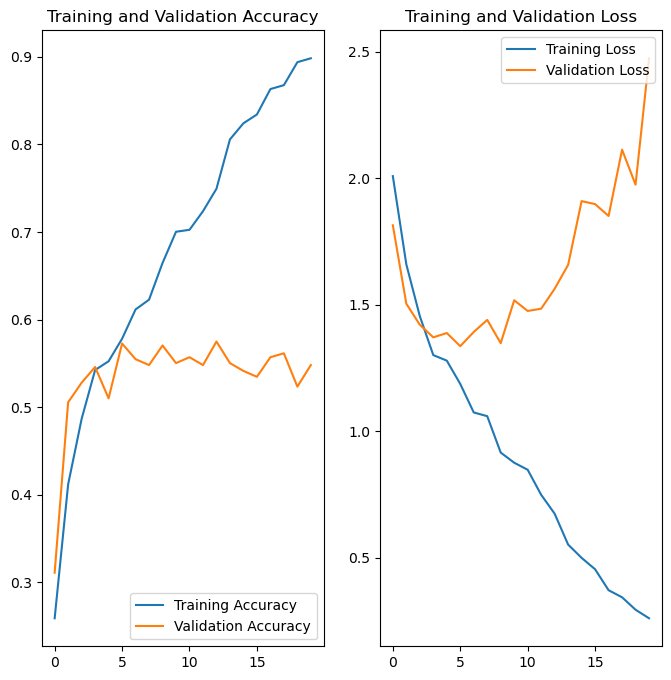

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
print(acc)

[0.2589285671710968, 0.4118303656578064, 0.4866071343421936, 0.5424107313156128, 0.5524553656578064, 0.578125, 0.6116071343421936, 0.6227678656578064, 0.6646205186843872, 0.7003348469734192, 0.7025669813156128, 0.7237723469734192, 0.7494419813156128, 0.8058035969734192, 0.82421875, 0.8342633843421936, 0.86328125, 0.8677455186843872, 0.8939732313156128, 0.8984375]


### MODEL 2

In [26]:
### Your code goes here
num_classes = 9

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.Flatten(),
  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  layers.Dense(128, activation='relu'),
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])


In [27]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [28]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - accuracy: 0.1877 - loss: 2.2092 - val_accuracy: 0.2550 - val_loss: 1.9530
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.3318 - loss: 1.8362 - val_accuracy: 0.4497 - val_loss: 1.6916
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.4173 - loss: 1.6762 - val_accuracy: 0.4273 - val_loss: 1.6135
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.4649 - loss: 1.5309 - val_accuracy: 0.4989 - val_loss: 1.4221
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.5212 - loss: 1.3685 - val_accuracy: 0.5101 - val_loss: 1.4503
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.5465 - loss: 1.3006 - val_accuracy: 0.5414 - val_loss: 1.3747
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.5608 - loss: 1.2584 - val_accuracy: 0.5213 - val_loss: 1.3137
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.5887 - loss: 1.1691 - val_accuracy: 0.5459 - v

### Visualizing training results

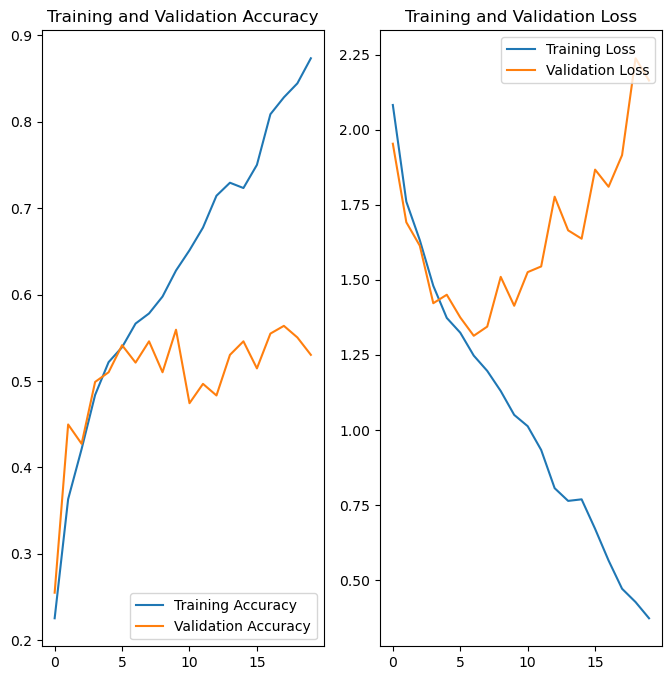

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### The model is still a overfit because the difference between the train and validation accuracy is huge. It is possible that the model will not perform well on a test set.

### MODEL - 3 

In [16]:
from tensorflow import keras
from tensorflow.keras import layers

# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    layers.RandomCrop(img_height,img_width),
  ]
)

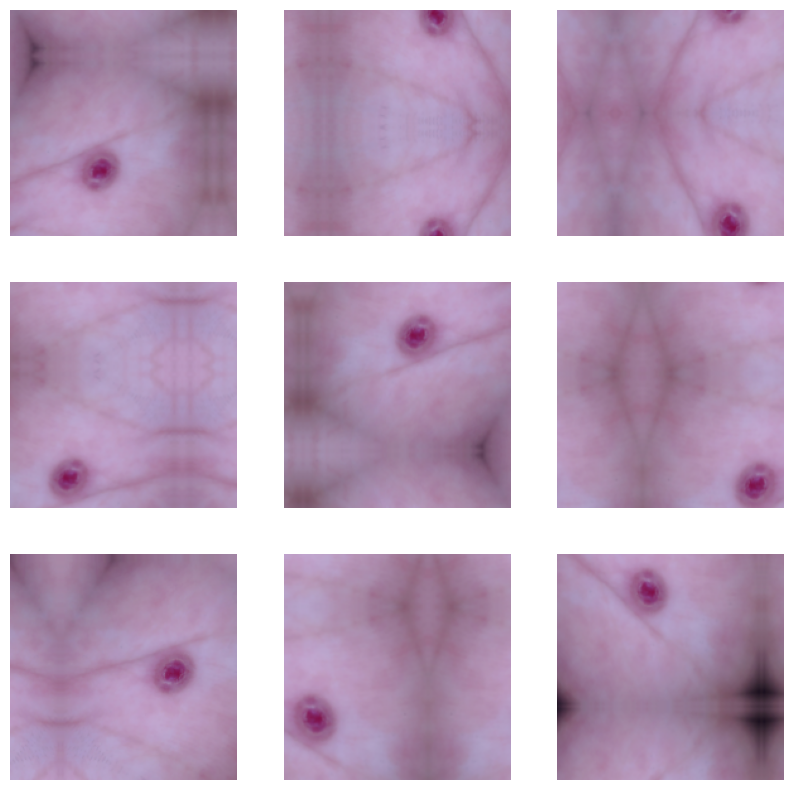

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model, compile and train the model


In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
num_classes = 9
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])




### Compiling the model

In [20]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 293s 5s/step - accuracy: 0.2016 - loss: 2.5260 - val_accuracy: 0.3535 - val_loss: 1.7894
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 271s 5s/step - accuracy: 0.3642 - loss: 1.7652 - val_accuracy: 0.2886 - val_loss: 1.9720
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 283s 5s/step - accuracy: 0.3168 - loss: 1.7746 - val_accuracy: 0.4228 - val_loss: 1.6658
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 271s 5s/step - accuracy: 0.3666 - loss: 1.6503 - val_accuracy: 0.4094 - val_loss: 1.6295
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 274s 5s/step - accuracy: 0.3792 - loss: 1.6379 - val_accuracy: 0.4183 - val_loss: 1.5804
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 315s 5s/step - accuracy: 0.3821 - loss: 1.6095 - val_accuracy: 0.3848 - val_loss: 1.6617
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 265s 5s/step - accuracy: 0.4069 - loss: 1.5933 - val_accuracy: 0.4318 - val_loss: 1.5901
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 263s 5s/step - accuracy: 0.3983 - loss: 1.6077 - val_accuracy: 0.4743 - v

### Visualizing the results

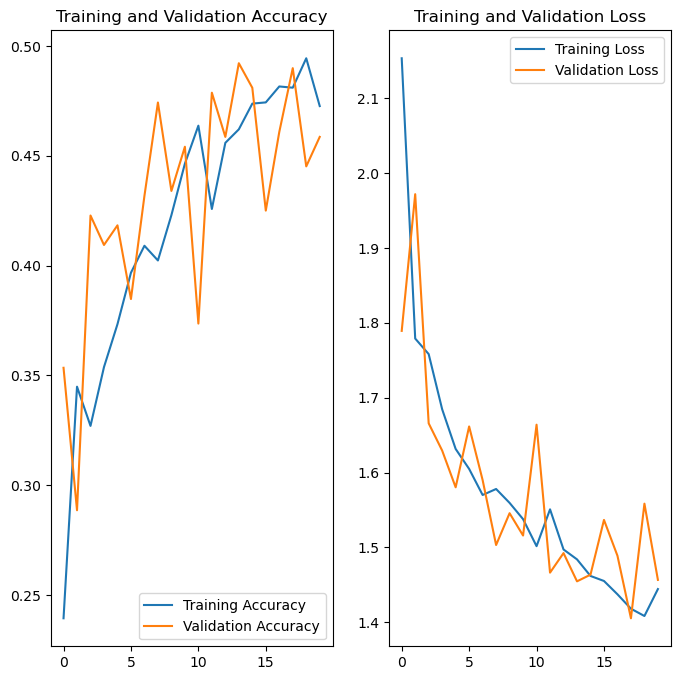

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
history.history['accuracy'][-1]

0.47265625

In [24]:
history.history['val_accuracy'][-1]

0.45861297845840454

#### Better model atleast the model is not an overfit because the training and the validation accuracy is closer.

#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [25]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [26]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,D:\Work\PG Programe\Melonima Assigment\unzippe...,actinic keratosis
1,D:\Work\PG Programe\Melonima Assigment\unzippe...,actinic keratosis
2,D:\Work\PG Programe\Melonima Assigment\unzippe...,actinic keratosis
3,D:\Work\PG Programe\Melonima Assigment\unzippe...,actinic keratosis
4,D:\Work\PG Programe\Melonima Assigment\unzippe...,actinic keratosis
...,...,...
2234,D:\Work\PG Programe\Melonima Assigment\unzippe...,vascular lesion
2235,D:\Work\PG Programe\Melonima Assigment\unzippe...,vascular lesion
2236,D:\Work\PG Programe\Melonima Assigment\unzippe...,vascular lesion
2237,D:\Work\PG Programe\Melonima Assigment\unzippe...,vascular lesion


Class=0, n=114 (5.092%)
Class=1, n=376 (16.793%)
Class=2, n=95 (4.243%)
Class=3, n=438 (19.562%)
Class=4, n=357 (15.945%)
Class=5, n=462 (20.634%)
Class=6, n=77 (3.439%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)


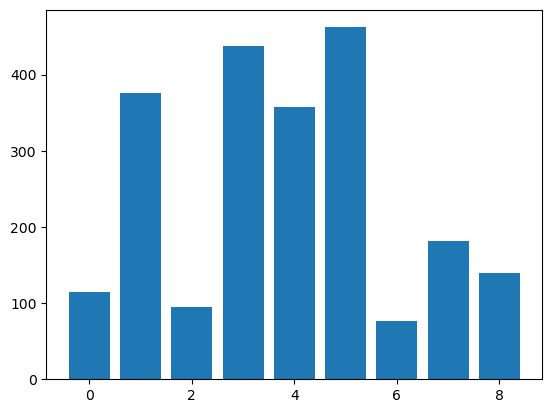

In [27]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

####  There is a class imbalance. The number of images for different categories are not evenly distributed.
#### - Which class has the least number of samples - 
###### Ans: class 6 has the least number of samples - seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
##### Ans:melanoma - this is the dominate class with more number of images


#### Rectified the class imbalance, by pumping in more data for all the class - By using Augmentor
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [32]:
#https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras

from sklearn.utils import class_weight
#Class=0, n=114 (5.092%)
#Class=1, n=376 (16.793%)
#Class=2, n=95 (4.243%)
#Class=3, n=438 (19.562%)
#Class=4, n=357 (15.945%)
#Class=5, n=462 (20.634%)
#Class=6, n=77 (3.439%)
#Class=7, n=181 (8.084%)
#Class=8, n=139 (6.208%)

class_weight = {0:5.09,
                1:16.79,
                2:4.24,
                3:19.56,
                4:15.94,
                5:20.63,
                6:3.43,
                7:8.08,
                8:6.20}

#class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)

### Your code goes here
num_classes = 9

#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  #2D convolution layer (e.g. spatial convolution over images).
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
  layers.MaxPooling2D(),

  #We slide over the feature map and extract tiles of a specified size.
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.MaxPooling2D(),

  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  ##Flattens the input. Does not affect the batch size.
  layers.Flatten(),

  #fully connected layer
  #A hidden layer in which each node is connected to every node in the subsequent hidden layer.
  #A fully connected layer is also known as a dense layer.

  layers.Dense(128, activation='relu'),

  #Dense is the only actual network layer in that model. A Dense layer feeds all outputs from the previous layer to all its neurons, each neuron providing one output to the next layer.
  #It's the most basic layer in neural networks. A Dense(10) has ten neurons. A Dense(512) has 512 neurons.
  #Dense implements the operation: output = activation(dot(input, kernel)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])


### Todo, choose an appropirate optimiser and loss function
#RMSprop. RMSprop is a very effective, but currently unpublished adaptive learning rate method
#Adam. Adam is a recently proposed update that looks a bit like RMSProp with momentum. The (simplified) update looks as follows:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  class_weight=class_weight)



Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 56s 902ms/step - accuracy: 0.2930 - loss: 25.7486 - val_accuracy: 0.3960 - val_loss: 1.8949
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 75s 779ms/step - accuracy: 0.4200 - loss: 21.2216 - val_accuracy: 0.4094 - val_loss: 1.8587
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 585ms/step - accuracy: 0.4729 - loss: 19.1166 - val_accuracy: 0.5213 - val_loss: 1.5456
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 36s 645ms/step - accuracy: 0.5213 - loss: 16.8547 - val_accuracy: 0.5280 - val_loss: 1.5984
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 573ms/step - accuracy: 0.5546 - loss: 15.4956 - val_accuracy: 0.4944 - val_loss: 1.4700
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 549ms/step - accuracy: 0.5703 - loss: 14.2892 - val_accuracy: 0.5481 - val_loss: 1.5298
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 567ms/step - accuracy: 0.6121 - loss: 13.7749 - val_accuracy: 0.4899 - val_loss: 1.7406
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 568ms/step - accuracy: 0.5941 - loss: 13.8112 - 

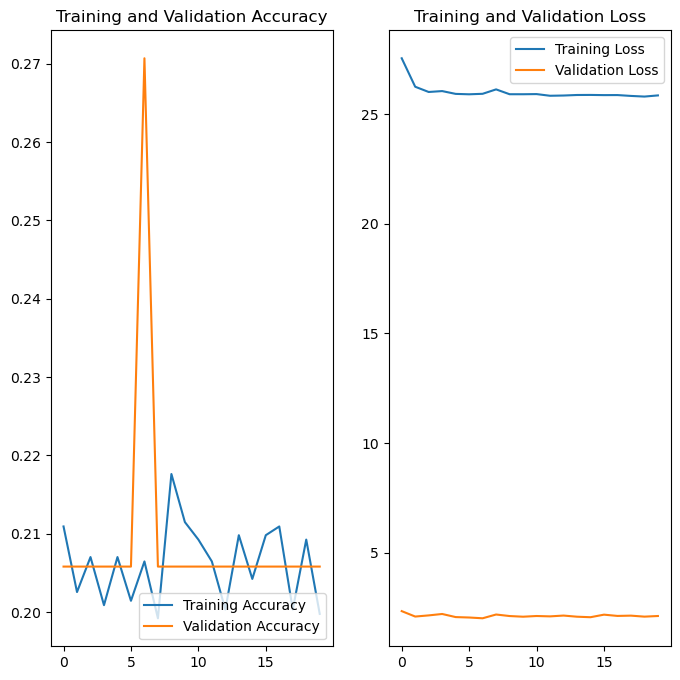

In [30]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [31]:
!pip install Augmentor

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for Augmentor from https://files.pythonhosted.org/packages/f3/86/5a91176650eb229ea2cd95551c34c36fba6cd95da3bdc4a5c73fbb1536ca/Augmentor-0.2.12-py2.py3-none-any.whl.metadata


In [1]:
#https://github.com/mdbloice/Augmentor
#https://github.com/mdbloice/Augmentor
datapath = "D:\\Work\\PG Programe\\Melonima Assigment\\unzipped\\Skin cancer ISIC The International Skin Imaging Collaboration\\train"
import Augmentor
p = Augmentor.Pipeline(datapath)
#Every function requires you to specify a probability, which is used to decide if an operation is applied to an image as it is passed through the augmentation pipeline.
p.rotate(probability=0.7, max_left_rotation=20, max_right_rotation=20)
p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
p.sample(500)
p.process()


Initialised with 2239 image(s) found.
Output directory set to D:\Work\PG Programe\Melonima Assigment\unzipped\Skin cancer ISIC The International Skin Imaging Collaboration\train\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1FE9615AE50>: 100%|█| 500/500 [00:31<00:
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1FE96471250>: 100%|█| 2239/2239 [01:49<00:00, 20.42 Sample


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [6]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("D:\\Work\\PG Programe\\Melonima Assigment\\unzipped\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\output")
data_dir_test = pathlib.Path("D:\\Work\\PG Programe\\Melonima Assigment\\unzipped\\Skin cancer ISIC The International Skin Imaging Collaboration\\Test")

In [10]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5478 files belonging to 9 classes.
Using 1095 files for validation.


In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)
  

Found 5478 files belonging to 9 classes.
Using 4383 files for training.


In [12]:
#overlaps data preprocessing and model execution while training., Speed up training
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [28]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

5478

In [29]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,D:\Work\PG Programe\Melonima Assigment\unzippe...,actinic keratosis
1,D:\Work\PG Programe\Melonima Assigment\unzippe...,actinic keratosis
2,D:\Work\PG Programe\Melonima Assigment\unzippe...,actinic keratosis
3,D:\Work\PG Programe\Melonima Assigment\unzippe...,actinic keratosis
4,D:\Work\PG Programe\Melonima Assigment\unzippe...,actinic keratosis
...,...,...
5473,D:\Work\PG Programe\Melonima Assigment\unzippe...,vascular lesion
5474,D:\Work\PG Programe\Melonima Assigment\unzippe...,vascular lesion
5475,D:\Work\PG Programe\Melonima Assigment\unzippe...,vascular lesion
5476,D:\Work\PG Programe\Melonima Assigment\unzippe...,vascular lesion


Class=0, n=292 (5.330%)
Class=1, n=904 (16.502%)
Class=2, n=235 (4.290%)
Class=3, n=1062 (19.387%)
Class=4, n=878 (16.028%)
Class=5, n=1129 (20.610%)
Class=6, n=192 (3.505%)
Class=7, n=447 (8.160%)
Class=8, n=339 (6.188%)


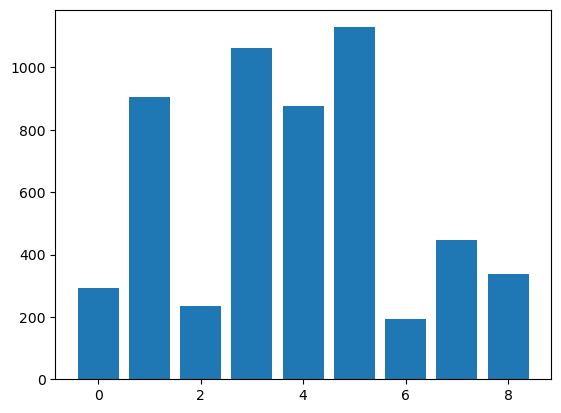

In [30]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()



### Lets see the distribution of augmented data after adding new images to the original training data.

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [31]:
batch_size = 32
img_height = 180
img_width = 180

In [13]:
num_classes = 9

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.Flatten(),
  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  layers.Dense(128, activation='relu'),
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])


####  Compile your model (Choose optimizer and loss function appropriately)

In [14]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

####   Train your model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 7444s 55s/step - accuracy: 0.2792 - loss: 1.9389 - val_accuracy: 0.4438 - val_loss: 1.5919
Epoch 2/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.4574 - loss: 1.5128 - val_accuracy: 0.4959 - val_loss: 1.4209
Epoch 3/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - accuracy: 0.5081 - loss: 1.3782 - val_accuracy: 0.5215 - val_loss: 1.4015
Epoch 4/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.5269 - loss: 1.3165 - val_accuracy: 0.5388 - val_loss: 1.3070
Epoch 5/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 347s 3s/step - accuracy: 0.5629 - loss: 1.2157 - val_accuracy: 0.5242 - val_loss: 1.3095
Epoch 6/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 298s 2s/step - accuracy: 0.5808 - loss: 1.1682 - val_accuracy: 0.5753 - val_loss: 1.2142
Epoch 7/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 365s 3s/step - accuracy: 0.6068 - loss: 1.0653 - val_accuracy: 0.5534 - val_loss: 1.2388
Epoch 8/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 349s 3s/step - accuracy: 0.6468 - loss: 1.0064 - val_ac

####  Visualize the model results

In [1]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'history' is not defined

In [3]:
# Test the model
data_dir_test = pathlib.Path("D:\\Work\\PG Programe\\Melonima Assigment\\unzipped\\Skin cancer ISIC The International Skin Imaging Collaboration\\Test")

In [2]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
           data_dir_test,
           shuffle=True,        #or False
           batch_size=32,
           image_size=(100,100),

SyntaxError: incomplete input (956127038.py, line 5)

In [ ]:
model.predict(test_dataset)

In [ ]:
### Analysis
####The model is still an overfit because the validation accuracy has dropped significantly.
